Scripts for manuscript in prep by Del Vecchio, Lathrop, Fratkin, Glade, Zwieback, Rowland and others on Teller 47 watershed surface processes

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import seaborn as sns
import matplotlib.colors as colors

import rasterio
from rasterio.plot import show
import fiona 
import geopandas as gpd
from rasterstats import zonal_stats
import rioxarray as rxr
import xarray

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import  GridSpec
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [2]:
if os.getlogin() == 'joanm':
    data_path = "C:\\Users\\joanm\\OneDrive - Dartmouth College\\NGEE_projects\\Teller_47\\Teller_47_Data\\"
elif os.getlogin() == 'f005dv1':
    data_path = "E:\\Del_Vecchio_OneDrive\\OneDrive - Dartmouth College\\NGEE_projects\\Teller_47\\Teller_47_Data\\"
else:
    print("Who are you people? Go set your data path somewhere else I gues")

# Get topo and slope maps (run once)

We are going to build a new slope map from the source DEM since we want to eliminate microtopography from our slope maps. So we coarsen the DEM to 10 meters from 2, then calculate slope on that raster, then upscale that raster back to 2 m so we can compare it with the 2 m drainage area array

In [3]:
import richdem as rd

In [4]:
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling

# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, target_res):
    # Forces into original target shape, will rewrite it for a better function later
    target_shape=(1979, 1818)
    
    t = raster.transform

    # rescale the metadata
    scale = t[0]/target_res
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    
    if raster.shape == target_shape:
        height = int(raster.height * scale)
        width = int(raster.width * scale)
    else: 
        height = target_shape[0]
        width = target_shape[1]
            

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.cubic,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)                     
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


with rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_dem.tif') as src:
    with resample_raster(src, target_res=10) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        print(repr(resampled))
        out_meta = resampled.meta.copy()
        with rasterio.open("new_dem.tif","w",**out_meta) as dest:
            dest.write(resampled.read(1),1)
        
        elev_10m = rd.LoadGDAL("new_dem.tif")
        new_slope = rd.TerrainAttribute(elev_10m, attrib='slope_degrees')

        with rasterio.open("new_slope.tif","w",**out_meta) as dest:
            print('Slope dims: {}'.format(dest.shape))
            dest.write(new_slope, 1) #https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
        #plt.imshow(new_slope)
        
        with rasterio.open("new_slope.tif") as src:
            with resample_raster(src, target_res=2) as resampled:
                print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
                print(repr(resampled))
                out_meta = resampled.meta.copy()
                with rasterio.open("new_slope_2m.tif","w",**out_meta) as dest:
                    dest.write(resampled.read(1),1)

        
        
        
#https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439
#with edits by me to turn height and width to integer if you want to downscale
#and automated scaling after providing desired output resolution (a little more intuitive)

Orig dims: (1979, 1818), New dims: (395, 363)
<open DatasetReader name='/vsimem/e5c2c738-0466-4cd0-a9d3-30b04f314975/e5c2c738-0466-4cd0-a9d3-30b04f314975.tif' mode='r'>
Slope dims: (395, 363)
Orig dims: (395, 363), New dims: (1979, 1818)
<open DatasetReader name='/vsimem/21cb957d-f846-42ca-8304-6f55a0719c39/21cb957d-f846-42ca-8304-6f55a0719c39.tif' mode='r'>


In [5]:
with rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_dem.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()
with rasterio.open('new_slope_2m.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()

(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)
(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)


I think I've done it

# dGPS

## GCPs

In [27]:
topo_labels = ["Slope (deg)", "Radiation (W/m2)", "Drainage area (m2)"]

In [28]:
df = pd.read_csv(data_path+"Teller_47_Data_dGPS\\T47_GCPs_extract.csv",na_values='-9999')


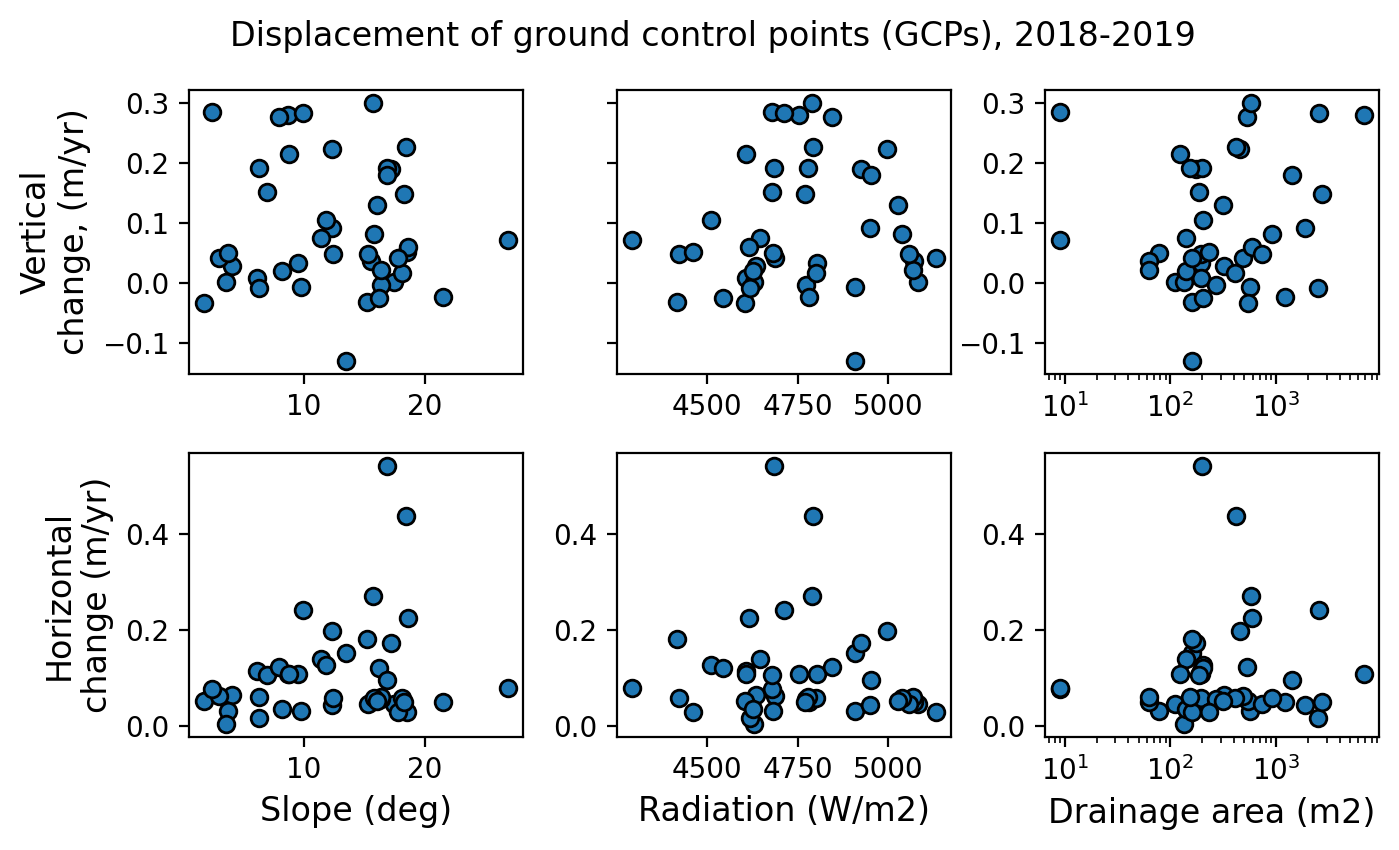

In [29]:
topos = df.columns[-3:]
diffs = ['dElev_1819', 'dDist_1819']


fig, axes = plt.subplots(2,3,figsize=(7,4), dpi=200)


for i, ax in enumerate(axes[0]):
    ax.scatter(x=df[topos[i]],y=(df[diffs[0]]), edgecolor='k')

for i, ax in enumerate(axes[1]):
    ax.scatter(x=df[topos[i]],y=(df[diffs[1]]), edgecolor='k')  
    ax.set_xlabel(topo_labels[i], fontsize=12)

axes[0,0].set_ylabel('Vertical\nchange, (m/yr)', fontsize=12)

axes[1,0].set_ylabel('Horizontal\nchange (m/yr)', fontsize=12)

axes[0,2].set_xscale('log')
axes[1,2].set_xscale('log')

axes[0,1].tick_params(labelleft=False) #Finish this in a loop!

fig.suptitle('Displacement of ground control points (GCPs), 2018-2019', fontsize=12, y=1.05)

fig.tight_layout()
plt.savefig("GCPs_vs_topos.png",  bbox_inches='tight')


In [229]:
df['combined'] = ((df[diffs[0]])**2 + (df[diffs[1]])**2)**0.5

# Don't divide by two here since it's only one year

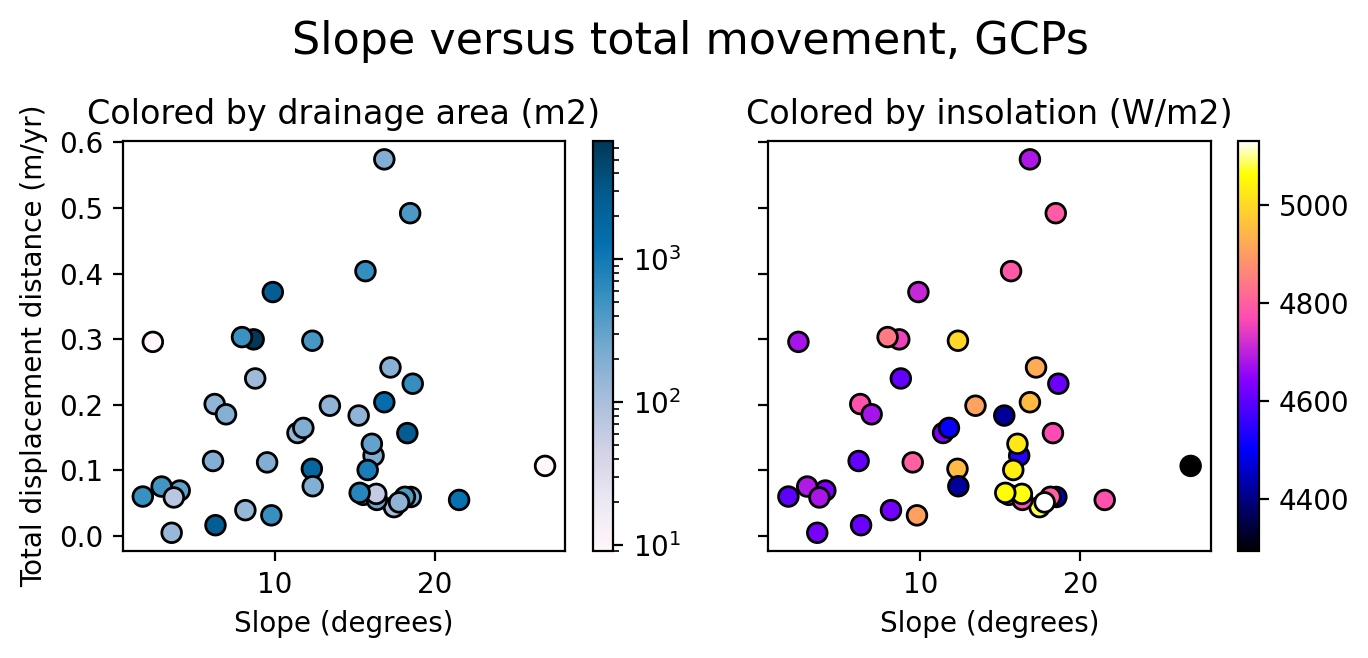

In [231]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), dpi=200, sharey=True)
im = ax1.scatter(df['slope'], y=df['combined'],c=df['flowac3m_1'],cmap='PuBu',norm=colors.LogNorm(), edgecolor='black', s=50)
cb = fig.colorbar(im, ax=ax1)
ax1.set_title('Colored by drainage area (m2)')
im = ax2.scatter(df['slope'],y=df['combined'],c=df['radiation'], cmap='gnuplot2', edgecolor='black', s=50)
cb = fig.colorbar(im, ax=ax2)
ax2.set_title('Colored by insolation (W/m2)');
fig.suptitle('Slope versus total movement, GCPs', fontsize=16, y=1.08)
ax1.set_ylabel('Total displacement distance (m/yr)')
ax1.set_xlabel('Slope (degrees)')
ax2.set_xlabel('Slope (degrees)')
fig.tight_layout()
fig.savefig('GCPs_color_scatters.png', dpi=200,  bbox_inches='tight')



## Lobes

In [32]:
df2 = pd.read_csv(data_path+"Teller_47_Data_dGPS\\T47_targets_extract.csv",na_values='-9999')

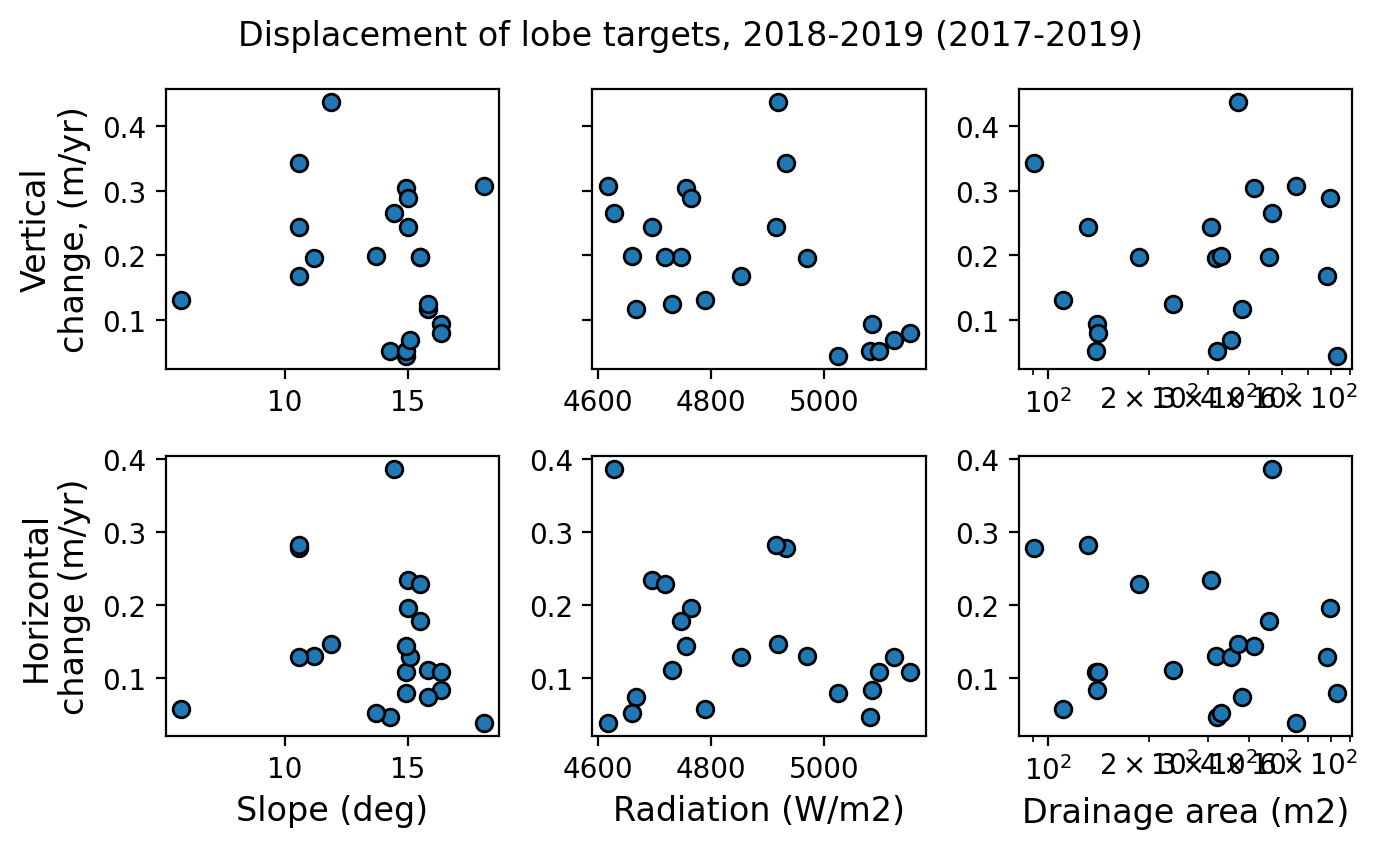

In [33]:
topos2 = df2.columns[-3:]
diffs2 = df2.columns[4:6]

fig, axes = plt.subplots(2,3,figsize=(7,4), dpi=200)


for i, ax in enumerate(axes[0]):
    ax.scatter(x=df2[topos2[i]],y=(df2[diffs2[0]]), edgecolor='k')

   
for i, ax in enumerate(axes[1]):
    ax.scatter(x=df2[topos2[i]],y=(df2[diffs2[1]]), edgecolor='k')  
    ax.set_xlabel(topo_labels[i], fontsize=12)
    

axes[0,0].set_ylabel('Vertical\nchange, (m/yr)', fontsize=12)

axes[1,0].set_ylabel('Horizontal\nchange (m/yr)', fontsize=12)

axes[0,2].set_xscale('log')
axes[1,2].set_xscale('log')

axes[0,1].tick_params(labelleft=False) #Finish this in a loop!

fig.suptitle('Displacement of lobe targets, 2018-2019 (2017-2019)', fontsize=12, y=1.05)

fig.tight_layout()
plt.savefig("Lobes_vs_topos.png", bbox_inches='tight')


In [34]:
df2['combined'] = ((df2[diffs2[0]]/2)**2 + (df2[diffs2[1]]/2)**2)**0.5
# divide by 2 since it's two years of displacement 

C:\Users\joanm\Anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


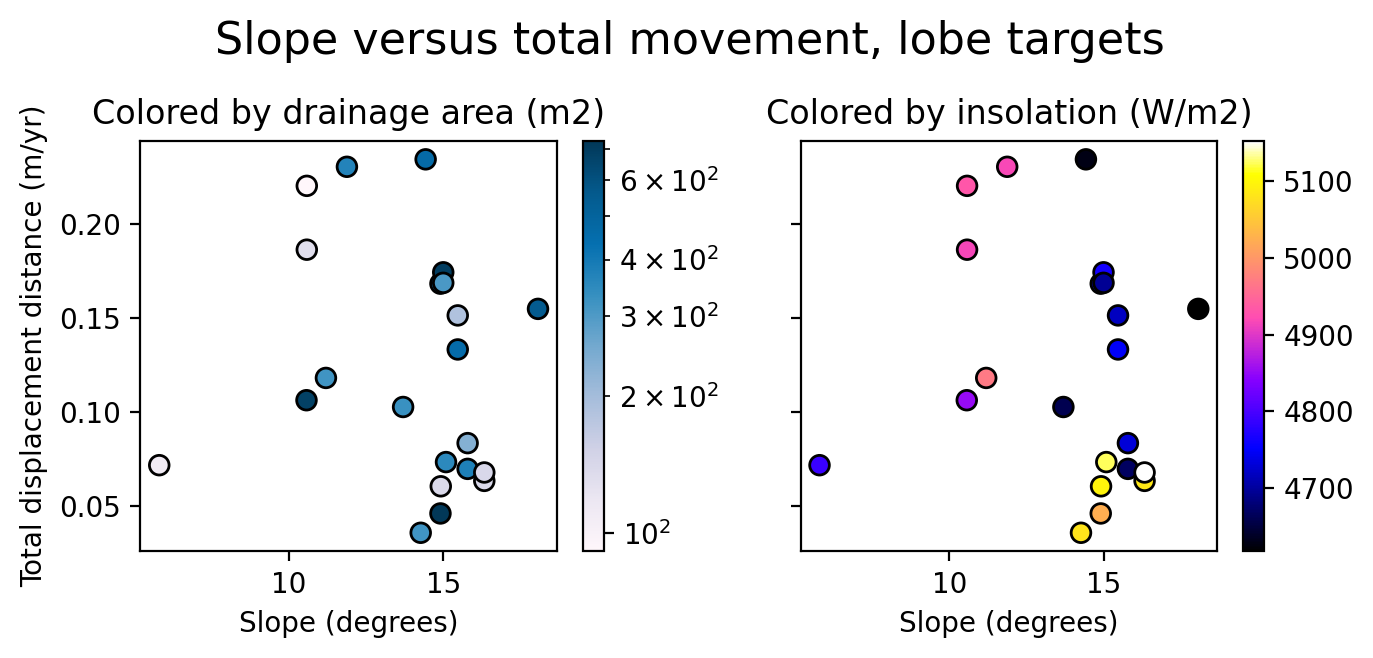

In [35]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3), dpi=200, sharey=True)
im = ax1.scatter(x=df2['slope'],y=df2['combined'],c=df2['flowacc'],cmap='PuBu',norm=colors.LogNorm(), edgecolor='black', s=50)
cb = fig.colorbar(im, ax=ax1)
ax1.set_title('Colored by drainage area (m2)')
im = ax2.scatter(x=df2['slope'],y=df2['combined'],c=df2['radiation'],cmap='gnuplot2', edgecolor='black', s=50)
cb = fig.colorbar(im, ax=ax2)
ax2.set_title('Colored by insolation (W/m2)');
fig.suptitle('Slope versus total movement, lobe targets', fontsize=16, y=1.08)
ax1.set_ylabel('Total displacement distance (m/yr)')
ax1.set_xlabel('Slope (degrees)')
ax2.set_xlabel('Slope (degrees)')
plt.tight_layout()
plt.savefig('lobe_color_scatters.png', dpi=200,  bbox_inches='tight')

## Combined target types

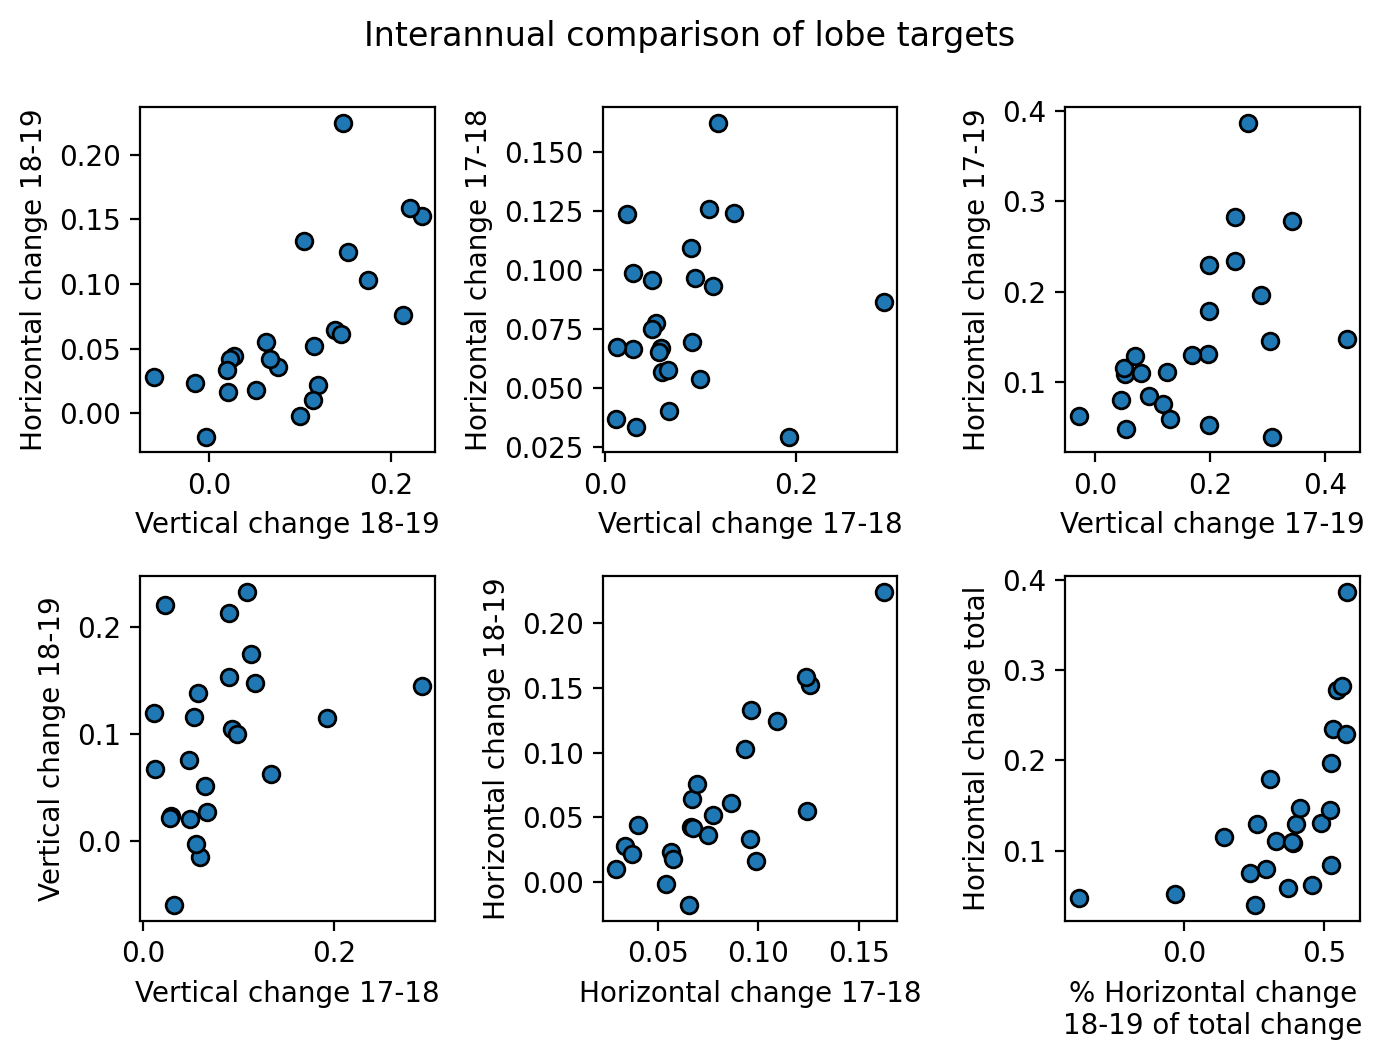

In [36]:
d17_19 = df2.columns[4:6]
d17_18 = df2.columns[7:9]
d18_19 = df2.columns[10:12]

fig, ax = plt.subplots(2,3,figsize=(7,5), dpi=200)
ax[0,2].scatter(x=df2[d17_19[0]],y=df2[d17_19[1]], edgecolor='k')
ax[0,1].scatter(x=df2[d17_18[0]],y=df2[d17_18[1]], edgecolor='k')
ax[0,0].scatter(x=df2[d18_19[0]],y=df2[d18_19[1]], edgecolor='k')
ax[1,0].scatter(x=df2[d17_18[0]],y=df2[d18_19[0]], edgecolor='k')
ax[1,1].scatter(x=df2[d17_18[1]],y=df2[d18_19[1]], edgecolor='k')
ax[1,2].scatter(x=(df2[d18_19[1]]/df2[d17_19[1]]),y=df2[d17_19[1]], edgecolor='k')

ax[0,2].set_xlabel('Vertical change 17-19')
ax[0,1].set_xlabel('Vertical change 17-18')
ax[0,0].set_xlabel('Vertical change 18-19')
ax[1,0].set_xlabel('Vertical change 17-18')
ax[1,1].set_xlabel('Horizontal change 17-18')
ax[1,2].set_ylabel('Horizontal change total')

ax[0,2].set_ylabel('Horizontal change 17-19')
ax[0,1].set_ylabel('Horizontal change 17-18')
ax[0,0].set_ylabel('Horizontal change 18-19')
ax[1,0].set_ylabel('Vertical change 18-19')
ax[1,1].set_ylabel('Horizontal change 18-19')
ax[1,2].set_xlabel('% Horizontal change\n18-19 of total change')

fig.suptitle('Interannual comparison of lobe targets', fontsize=12, y=1.05)
fig.tight_layout()
fig.savefig('lobe_crossplots.png', dpi=200,  bbox_inches='tight')

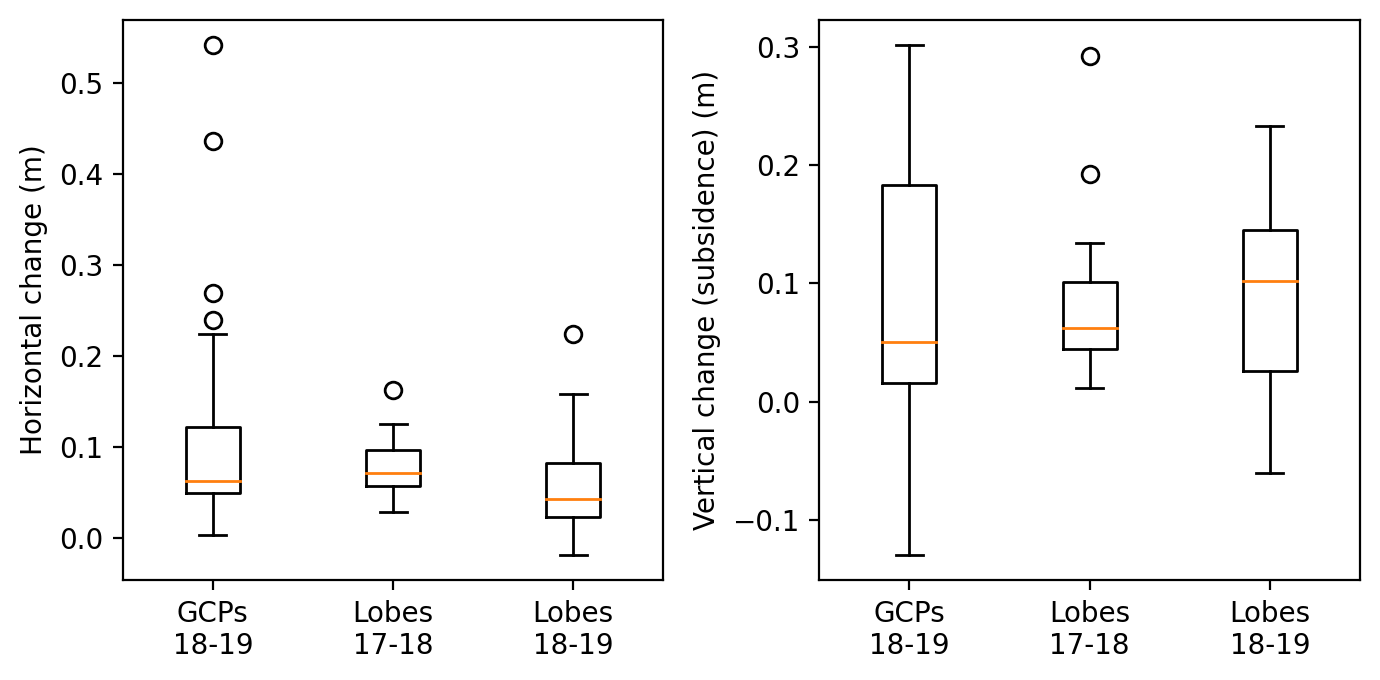

In [37]:
elevation_change = [df['dElev_1819'],  df2[d17_18[0]], df2[d18_19[0]]]

position_change = [df[d18_19[1]], df2[d17_18[1]], df2[d18_19[1]]]

fig, ax = plt.subplots(1,2, figsize=(7,3.5), dpi=200)
ax[0].boxplot(position_change)
ax[0].set_xticklabels(['GCPs\n18-19', 'Lobes\n17-18', 'Lobes\n18-19'])
ax[1].boxplot(elevation_change)
ax[1].set_xticklabels(['GCPs\n18-19', 'Lobes\n17-18', 'Lobes\n18-19'])


ax[0].set_ylabel('Horizontal change (m)')
ax[1].set_ylabel('Vertical change (subsidence) (m)')

fig.tight_layout()
fig.savefig('x_boxplot.png', dpi=200,  bbox_inches='tight')

# dGPS map figures

To replace Arc-made maps, under construction

# Insar vs meteo

## Just 2017-2019 data, probably should be replaced by querying complete dataset in 4.2

In [38]:
dfd = pd.read_csv(data_path+"insar_displacements.csv",index_col='Year',parse_dates=True)
dfc = pd.read_csv(data_path+"Nome_climate_data.csv",index_col='Date',parse_dates=True)

In [39]:
for i,yr in enumerate(['2017','2018','2019']):
    dfc.loc[yr,'Precip cumsum in'] = dfc.loc[yr,'Precipitation (Inches)'].cumsum()
    dfc.loc[yr, 'Precip cumsum mm'] = dfc.loc[yr,'Precip cumsum in'] * 25.4
    dfc.loc[yr, 'Mean Temp (C)'] = (dfc.loc[yr,'Mean Temp (F)'] - 32) * (5/9)
    dfc.loc[yr,'Mean rolling F'] = dfc.loc[yr,'Mean Temp (F)'].rolling(5).mean()
    dfc.loc[yr,'Mean rolling C'] = (dfc.loc[yr,'Mean rolling F'] - 32) * (5/9)
    #dfc.loc[yr,'Departure, mean rolling'] = dfc.loc[yr,'Mean Temp (F)'] - dfc.loc[yr,'Mean Temp (F)'].rolling(5).mean()
    
dfc['Precip, mm'] = dfc['Precipitation (Inches)']*25.4

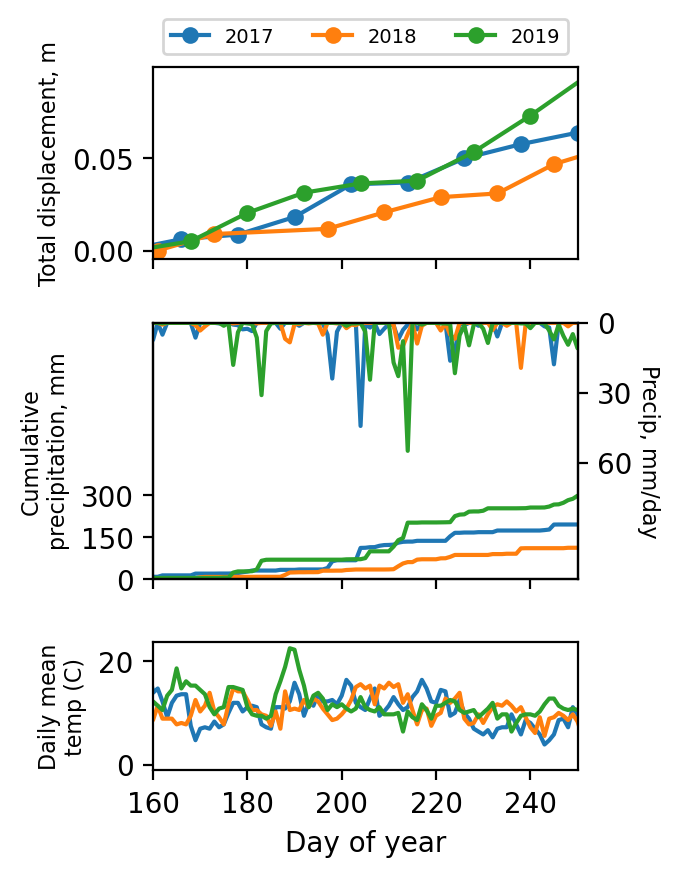

In [40]:
fig, ax = plt.subplots(3,1,figsize=(3.5,4.5),dpi=200,sharex=True,gridspec_kw={'height_ratios':[1.5,2,1]})

for i,yr in enumerate(['2017','2018','2019']):
    dfc[yr].plot(ax=ax[2],x='doy',y='Mean Temp (C)',legend=False)

    
for i,yr in enumerate(['2017','2018','2019']):
    dfc[yr].plot(ax=ax[1],x='doy',y='Precip cumsum mm',legend=False)

ax[1].set_ylim(0, dfc['Precip cumsum mm'].max()*2.5)

ax2=ax[1].twinx()

for i,yr in enumerate(['2017','2018','2019']):
    dfc[yr].plot(ax=ax2,x='doy',y='Precip, mm',legend=False)

ax2.set_ylim(dfc['Precip, mm'].max()*2,0)
ax2.set_ylabel('Precip, mm/day',rotation=270, labelpad=10, fontsize=8)
ax2.set_yticks([0, 30, 60])
    
for i,yr in enumerate(['2017','2018','2019']):
    dfd[yr].plot(ax=ax[0],x='doy',y='W',marker=".",markersize="10",label=yr)

ax[0].set_xlim(160,250)
ax[0].set_ylabel('Total displacement, m', fontsize=8)
ax[0].legend(loc='upper left',ncol=3,fontsize=7, bbox_to_anchor=(0.0, 1.3))
ax[1].set_ylabel('Cumulative\nprecipitation, mm', fontsize=8)
ax[1].set_yticks([0, 150, 300])
ax[2].set_ylabel('Daily mean\ntemp (C)', fontsize=8)
ax[2].set_xlabel('Day of year')

fig.tight_layout()
fig.savefig('InSAR_vs_weather_data.png', dpi=200)


In [ ]:
dfc['doy_Year'] = dfc.index.year.values
dfd['doy_Year'] = dfd.index.year.values

In [ ]:
df_combined = pd.merge(dfc, dfd, how="outer", on=['doy_Year','doy'])
df_combined.to_csv("InSAR_plus_weather_data.csv")

Still to do: try a scatter plot with InSAR displacement vs cumulative rainfall, average temp leading up to day of measurement 

In [ ]:
# Something like, cumulative rainfall and net temp change between indices where insar data isn't nan 

## All historical Nome data

In [41]:
nome = pd.read_csv(data_path+"Teller_47_Data_Meteo//nome_airport_data_all.csv",header=5, parse_dates=True, index_col="Date")

In [42]:
nome['Year'] = nome.index.year.values
nome['Month'] = nome.index.month.values
nome['doy'] = nome.index.dayofyear.values

In [43]:
nome['Precip_mm'] = nome['Precipitation (in)'] * 25.4
nome['Snow_mm'] = nome['Snowfall (in)'] * 25.4
nome['Temp_Mean_C'] = (nome['Mean Temperature (degF)']-32) * (5/9)

In [44]:
nome['Cum_precip'] = nome.groupby(by="Year")['Precip_mm'].cumsum()

In [45]:
nome['Cum_DDT'] = nome[nome["Temp_Mean_C"] > 0.0].groupby(by="Year")['Temp_Mean_C'].cumcount()

In [81]:
# Get day of year of date of max precip
idx = nome.groupby(['Year'])["Precip_mm"].idxmax()
#https://stackoverflow.com/questions/64865421/find-max-by-year-and-return-date-on-which-max-occurred-in-pandas-dataframe
idx = idx.dropna()


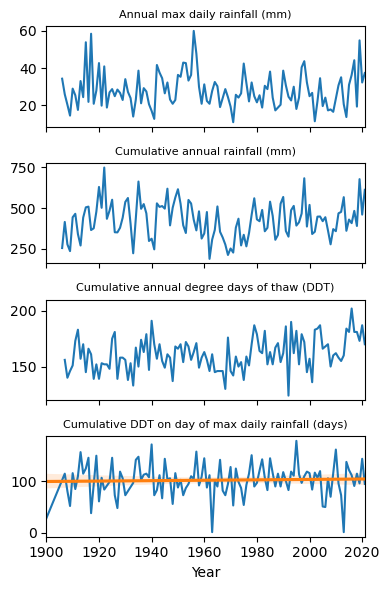

In [90]:
fig, ax = plt.subplots(4,1, figsize=(4,6), sharex=True, dpi=100)
ax[0].plot(nome.groupby(by="Year").max().Precip_mm[:-1])
ax[0].set_title("Annual max daily rainfall (mm)", fontsize=8)
ax[1].plot(nome.groupby(by="Year").max().Cum_precip[:-1])
ax[1].set_title("Cumulative annual rainfall (mm)", fontsize=8)
ax[2].plot(nome.groupby(by="Year").max().Cum_DDT[:-1])
ax[2].set_title("Cumulative annual degree days of thaw (DDT)", fontsize=8)
ax[2].set_ylim(120)
# Get cumulative degree days of thaw at time of largest rainstorm
sns.lineplot(x=nome.loc[idx, 'Year'], y=nome.loc[idx, 'Cum_DDT'],ax=ax[3])
sns.regplot(x=nome.loc[idx, 'Year'], y=nome.loc[idx, 'Cum_DDT'], order=1, scatter=False, ax=ax[3])
ax[3].set_title("Cumulative DDT on day of max daily rainfall (days)", fontsize=8)
ax[3].set_ylabel(None)
fig.tight_layout()
plt.savefig("Nome historical thaw and rainfall.png",  bbox_inches='tight')

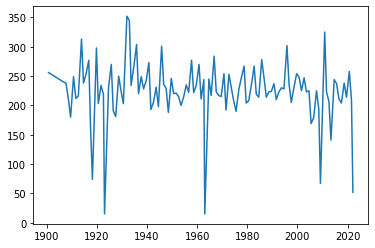

In [55]:
# Get day of year of date of max precip
idx = nome.groupby(['Year'])["Precip_mm"].idxmax()
#https://stackoverflow.com/questions/64865421/find-max-by-year-and-return-date-on-which-max-occurred-in-pandas-dataframe
idx = idx.dropna()
plt.plot(nome.loc[idx, 'doy'])

In [1]:
# Just for fun here's the fit since the 80

In [60]:
nome_80 = nome.loc[nome['Year']> 1979]

idx = nome_80.groupby(['Year'])["Precip_mm"].idxmax()
#https://stackoverflow.com/questions/64865421/find-max-by-year-and-return-date-on-which-max-occurred-in-pandas-dataframe
idx = idx.dropna()

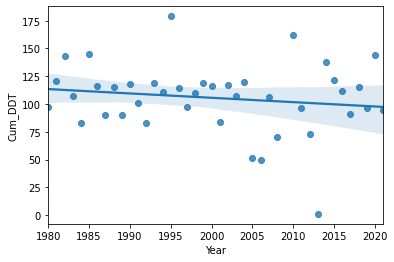

In [61]:
sns.regplot(x=nome_80.loc[idx, 'Year'], y=nome.loc[idx, 'Cum_DDT'], order=1)

# Slope stability

[SHALSTAB model of Montgomery and Dietrich (1994)](https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/93WR02979?casa_token=vJQ2NGNS82oAAAAA:obDGuoYXpnRkNKJfjXDhhWeQpUtJEy79XBb_eaRFalD2iSjzrXz5JUh_5_1y91WT1Qn3INazspBQllc) and constants to compare against [Mithan et al 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL092264?casa_token=KJynib3aO6kAAAAA%3AxN8ZEirJAHu_58RXNywm_r2wlYQtc0i44WpvXrCJDgA3Rimlc_7NleBwcRR5CDDJ3WqrpYq3xhZq8g) 

## Load rasters

In [3]:
slope = rasterio.open("new_slope_2m.tif", masked=True)
slope_data=slope.read(1)
slope_data[slope_data < 0.0] =np.nan
drainage_area = rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_acc.tif', masked=True)
a = drainage_area.read(1).astype(np.float32)
a[a < 0.0] =np.nan

## SHALSTAB

In [7]:
slope_normal_soil_thickness = np.cos(np.radians(slope_data))

 #flow accumulation [m^2] (flow acc currently in pixels,
#would mutliply by 2 for drainage area in m2 since 2m DEM but since
#'b' is length of countour also 2 m, they cancel out)

q_aug = .05; #[m/day] rain Aug 2 2020
z = 1; #active layer thickness, [m]
tanphi = .84; # original; tan (40 degrees) i think??? internal angle of friction
s_w_dens = 2; #ratio of density of saturated soil to water 
Ksat_maybe = 2.2; #m/day if 1/3 is organic and 2/3 is mineral 

##For reference, Mithan et al used:
# tanphi = 0.48 (for 26 degrees) and tanphi=0.32 (for 18 degrees), Harris and Lewkowicz (2000). 
# s_w_dens = 1.88 (H and L)
# z=1.5 (Harris et al. 2008)
#Ksat = 9 E-4 to 9 E-1 (Anderson and Anderson)

q_cr_T = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi));
#critical rainfall / transmissivity

q_cr_K = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#critical rainfall / hydraulic conductivity [T = K cos(theta) z]

k_aug_crit = q_aug / ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a )* (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#hydraulic conductivity that just crosses failure threshold for Aug 2
#rainfall event

q_cr= ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness * Ksat_maybe;

# Make critical rainfall mm for plotting 
q_cr_plot=q_cr*1000

# Make zeros very smol so logarithms work
q_cr_plot[q_cr_plot < 0.0] = 1E-7

# with rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_dem.tif') as src:
#     out_meta = src.meta.copy()
#     with rasterio.open("q_cr.tif","w",**out_meta) as dest:
#         dest.write(q_cr_plot,1)
with rasterio.open("q_cr.tif","w",**out_meta) as dest:
    dest.write(q_cr_plot,1)

C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less


## Absolutely losing my mind with this

In [478]:
h_nums = np.arange(0.1, 2.0, 0.1)
d_over_h_nums =  [(1.0)]


h, d_over_h = np.meshgrid(h_nums, d_over_h_nums)
d = d_over_h * h

rho_w = 1.0
rho_sat = 1.88
rho_dry = 1.2
g = 9.8
example_slope = .3
tanphi = .32


rho_b_av = ((rho_sat * d) + rho_dry*(h-d)) / h
Fd1a =   (rho_b_av * g * h * (np.cos(example_slope) * (np.cos(example_slope))))
Fd1b = rho_w * g * d
Fd = (Fd1a - Fd1b) * tanphi
Fr = rho_b_av * g * h * np.sin((example_slope)) * np.cos((example_slope))
Fs = Fd/Fr

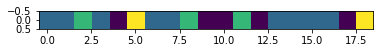

In [479]:
plt.imshow(Fs)

In [180]:
from matplotlib import colors

from matplotlib import cm
viridis = cm.get_cmap('plasma', 8)
newcolors = viridis(np.linspace(0, 1, 7))
withblack = np.vstack(([0.,0.,0.,1.0], newcolors))


# make a color map of fixed colors
cmap = colors.ListedColormap(withblack)
bounds=np.hstack((np.linspace(0,60,7), [61]))
norm = colors.BoundaryNorm(bounds, cmap.N)

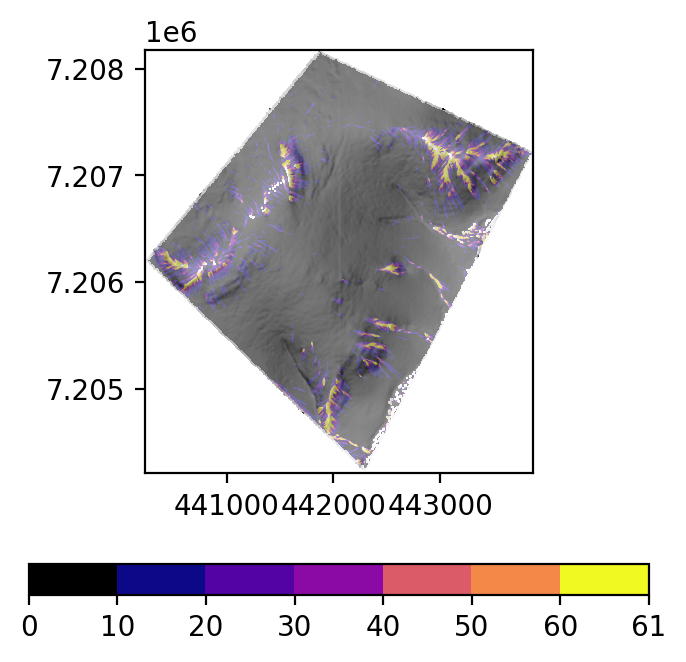

In [194]:
test = gpd.read_file(data_path+'Teller_47_Data_Shapefiles\\poly_failure_TL47_2018_jcr.shp')
test= test.to_crs('epsg:32603')
test["area (m2)"] = test['geometry'].area

UAS = gpd.read_file(data_path+'Teller_47_Data_Shapefiles\\2018UASExtent.shp')
UAS= UAS.to_crs('epsg:32603')
UAS["area (m2)"] = UAS['geometry'].area
UAS.to_file(data_path+'Teller_47_Data_Shapefiles\\failures_12N')

slope = rasterio.open('new_slope.tif', masked=True)

poly_extent = np.asarray(UAS.geometry.total_bounds)[[0,2,1,3]]
test_bounds = np.asarray(slope.bounds)[[0,2,1,3]]*3

with rasterio.open('new_slope.tif', masked=True) as slope:
    with rasterio.open("q_cr.tif") as q_cr:
        fig, ax = plt.subplots(figsize=(4,4), dpi=200)
        im0 = rasterio.plot.show(slope, cmap='binary', vmin=0, vmax=45,  ax=ax, zorder=0)
        im1 = rasterio.plot.show(q_cr, cmap=cmap, norm=norm, vmin=10, vmax=60,  ax=ax, alpha=0.4, zorder=1)
        #qcr_colors = ax.imshow(q_cr.read(1), cmap=cmap, norm=norm, vmin=10, vmax=60)
        fig.colorbar(qcr_colors, ax=ax, orientation='horizontal')
        
        plt.savefig("q_cr.png")

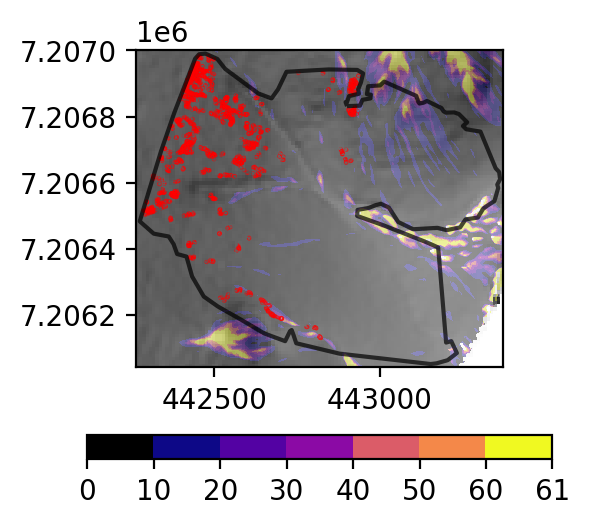

In [195]:
with rasterio.open('new_slope.tif', masked=True) as slope:
    with rasterio.open("q_cr.tif") as q_cr:      
        fig, ax = plt.subplots(figsize=(3,3), dpi=200)
        slopecolors = ax.imshow(slope.read(1), vmin=0, vmax=30, 
                                 cmap='Greys')
        im0 = rasterio.plot.show(slope, cmap='binary', vmin=0, vmax=45, extent=poly_extent, ax=ax, zorder=0)
        qcr_colors = ax.imshow(q_cr.read(1), cmap=cmap, norm=norm, vmin=10, vmax=60)
        im1 = rasterio.plot.show(q_cr,cmap=cmap, norm=norm, vmin=10, vmax=60, extent=poly_extent, ax=ax, alpha=0.4, zorder=1)
        b1 = test.boundary.plot(ax=ax, color='r', alpha=0.7, zorder=2)
        b2 = UAS.boundary.plot(ax=ax, color='k', alpha=0.7, zorder=2)
        ax.set_ylim(poly_extent[2]-10,poly_extent[3]+10)
        ax.set_xlim(poly_extent[0]-10,poly_extent[1]+10)
        fig.colorbar(qcr_colors, ax=ax, orientation='horizontal')
        
        plt.savefig("q_cr_zoom.png")

In [11]:
steepness = slope_data * np.sqrt(a)

with rasterio.open("steepness.tif","w",**out_meta) as dest:
    dest.write(steepness,1)

## Load failure polygons

In [4]:
test = gpd.read_file(data_path+'Teller_47_Data_Shapefiles\\poly_failure_TL47_2018_jcr.shp')
test= test.to_crs('epsg:32603')
test["area (m2)"] = test['geometry'].area

UAS = gpd.read_file(data_path+'Teller_47_Data_Shapefiles\\2018UASExtent.shp')
UAS= UAS.to_crs('epsg:32603')
UAS["area (m2)"] = UAS['geometry'].area
UAS.to_file(data_path+'Teller_47_Data_Shapefiles\\failures_12N')

slope = rasterio.open('new_slope.tif', masked=True)

#Only keep polygons > 2m2 since that's the resolution of the raster
#bigpolys = test[test["area (m2)"]>2.0]
#eh, unclear if needed u know


#https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

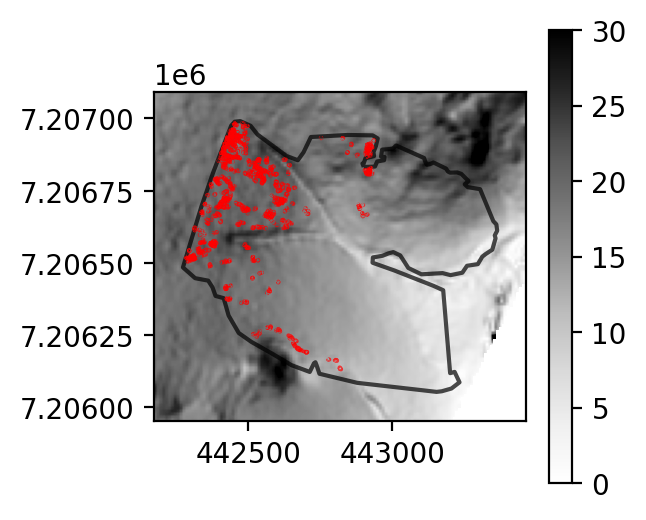

In [5]:
poly_extent = np.asarray(UAS.geometry.total_bounds)[[0,2,1,3]]
test_bounds = np.asarray(slope.bounds)[[0,2,1,3]]*3

fig, ax = plt.subplots(figsize=(3,3), dpi=200)
imx = ax.imshow(slope.read(1), vmin=0, vmax=30, 
                         cmap='Greys')
im0 = rasterio.plot.show(slope, cmap='binary', vmin=0, vmax=30, extent=test_bounds, ax=ax, zorder=0)                            
im1 = test.boundary.plot(ax=ax, color='r', alpha=0.7, zorder=2)
im2 = UAS.boundary.plot(ax=ax, color='k', alpha=0.7, zorder=1)
ax.set_ylim(poly_extent[2]-100,poly_extent[3]+100)
ax.set_xlim(poly_extent[0]-100,poly_extent[1]+100)
fig.colorbar(imx, ax=ax)

In [198]:
dinf_raster = rxr.open_rasterio(data_path+'Teller_47_Data_Rasters\\t47_acc.tif', masked=True)

da_clipped = dinf_raster.rio.clip(UAS.geometry)

C:\Users\joanm\Anaconda3\lib\site-packages\xarray\plot\plot.py:1451: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(x.dtype, str)
C:\Users\joanm\Anaconda3\lib\site-packages\xarray\plot\plot.py:1466: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  and not np.issubdtype(y.dtype, str)


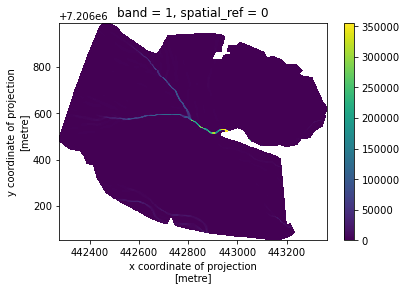

In [199]:
da_clipped.plot()

In [200]:
# Get  all coordinates in 2 m dinf raster

(X_c, Y_c) = np.meshgrid(da_clipped.x.values, da_clipped.y.values)

X_c = X_c.reshape((np.prod(X_c.shape),))
Y_c = Y_c.reshape((np.prod(Y_c.shape),))

coords = [(x,y) for x, y in zip(X_c, Y_c)]


In [201]:
from shapely.geometry import Point
from geopandas import GeoDataFrame

geometry = [Point(xy) for xy in coords]
points = GeoDataFrame(coords, crs="EPSG:32603", geometry=geometry)

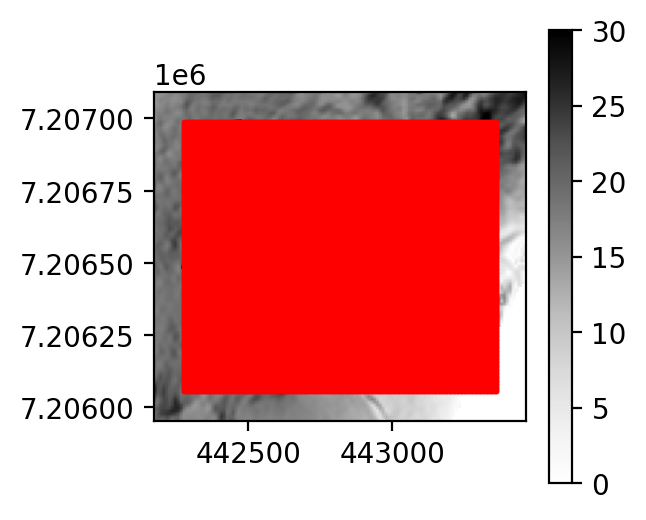

In [202]:
poly_extent = np.asarray(UAS.geometry.total_bounds)[[0,2,1,3]]
test_bounds = np.asarray(slope.bounds)[[0,2,1,3]]*3

fig, ax = plt.subplots(figsize=(3,3), dpi=200)
imx = ax.imshow(slope.read(1), vmin=0, vmax=30, 
                         cmap='Greys')
im0 = rasterio.plot.show(slope, cmap='binary', vmin=0, vmax=30, extent=test_bounds, ax=ax, zorder=0)                            
im1 = test.boundary.plot(ax=ax, color='k', alpha=0.7, zorder=2)
im2 = UAS.boundary.plot(ax=ax, color='k', alpha=0.7, zorder=1)
im3 = points.plot(ax=ax, color='r', alpha=0.7, markersize=.1, zorder=3)
ax.set_ylim(poly_extent[2]-100,poly_extent[3]+100)
ax.set_xlim(poly_extent[0]-100,poly_extent[1]+100)
fig.colorbar(imx, ax=ax)

In [203]:
df_points = pd.DataFrame()

In [204]:
import fiona
import rasterio
import rasterio.mask

with fiona.open(data_path+'Teller_47_Data_Shapefiles\\failures_12N', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open('new_slope.tif', masked=True) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('new_slope_clipped.tif', "w", **out_meta) as dest:
    dest.write(out_image)
    
with fiona.open(data_path+'Teller_47_Data_Shapefiles\\failures_12N', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_acc.tif', masked=True) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_acc_clipped.tif', "w", **out_meta) as dest:
    dest.write(out_image)

In [205]:
raster = rasterio.open(data_path+'Teller_47_Data_Rasters\\t47_acc_clipped.tif', masked=True)
src = raster
df_points['dinf'] = [x[0] for x in src.sample(coords)]
print('done dinf')
raster.close()

raster = rasterio.open('new_slope_clipped.tif', masked=True)
src = raster
df_points['slope'] = [x[0] for x in src.sample(coords)]
raster.close()

done dinf


In [206]:
df_points = df_points[df_points['dinf'] > 0.0]

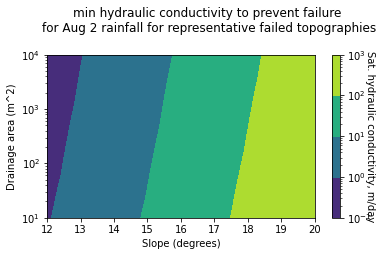

In [207]:
#slopes - between 14 and 20
#DA - between 0 and 2000
pts=20
slope_array=np.linspace(12,20,num=pts)
da_array=np.geomspace(1e1,1e4,num=pts)
slope_normal_array = np.cos(np.radians(slope_array))
k_aug_crit_matrix=np.zeros((pts,pts))

for i in range(len(slope_array)):
    for j in range(len(da_array)):
        k_aug_crit_matrix[i,j] = q_aug / ((np.sin(np.radians(slope_array[i])) *
                       (s_w_dens)) / da_array[j] )* (1 -  (np.tan(np.radians(slope_array[i])) / tanphi)) * z * slope_normal_array[i];

##Explore this param scape as function of soil thickness
from matplotlib import ticker, cm
fig, ax = plt.subplots(figsize=(6,3))
CS = ax.contourf(slope_array,da_array,k_aug_crit_matrix,locator=ticker.LogLocator())
#ax.clabel(CS, inline=1)
ax.set_yscale('log')
cbar = fig.colorbar(CS)
fig.suptitle('min hydraulic conductivity to prevent failure \nfor Aug 2 rainfall for representative failed topographies',y=1.1)
plt.xlabel('Slope (degrees)')
plt.ylabel('Drainage area (m^2)')
cbar.set_label('Sat. hydraulic conductivity, m/day', rotation=270)

### Get mapped failures shapefile and turn them into points. 

In [6]:
test = gpd.read_file(data_path+'Teller_47_Data_Shapefiles\\poly_failure_TL47_2018_jcr.shp')
test= test.to_crs('epsg:32603')
test["area (m2)"] = test['geometry'].area

#Only keep polygons > 2m2 since that's the resolution of the raster
#bigpolys = test[test["area (m2)"]>2.0]
#eh, unclear if needed u know


#https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas

In [7]:
#Need to reproject shapefile to match raster

test= test.to_crs('epsg:32603')

#Also want to use a broader measure of slope 

#all_touched=True

dinf_stats = zonal_stats(test, data_path+'Teller_47_Data_Rasters\\t47_acc.tif', all_touched=True)

slope_stats = zonal_stats(test, "new_slope.tif", all_touched=True)
#slope_stats = zonal_stats(test, "new_slope.tif", all_touched=True)

Seems like new_slope.tif might not be in the right projection

In [210]:
df_dinf = pd.DataFrame(dinf_stats).add_prefix('dInf_')
df_slope = pd.DataFrame(slope_stats).add_prefix('slope_')

df_stats = pd.merge(df_dinf, df_slope, how='outer', left_index=True, right_index=True)

df_stats["area (m2)"] = test['geometry'].area
drops = df_stats.dropna()
df_stats

,dInf_min,dInf_max,dInf_mean,dInf_count,slope_min,slope_max,slope_mean,slope_count,area (m2)
0,287.0,290.0,288.666667,3,17.262379,17.262379,17.262379,1,0.707943
1,286.0,344.0,312.250000,4,17.262379,17.262379,17.262379,1,1.176804
2,299.0,322.0,310.500000,2,17.262379,17.262379,17.262379,1,0.330015
3,314.0,398.0,367.666667,3,17.262379,17.262379,17.262379,1,2.545543
4,339.0,430.0,384.500000,2,16.547785,16.547785,16.547785,1,0.442713
...,...,...,...,...,...,...,...,...,...
1190,293.0,519.0,406.000000,2,13.687014,13.687014,13.687014,1,0.131855
1191,636.0,645.0,640.500000,2,18.176121,18.176121,18.176121,1,0.874568
1192,965.0,995.0,980.000000,2,18.176121,18.176121,18.176121,1,0.280764
1193,1090.0,1190.0,1140.000000,2,18.724949,19.438610,19.081779,2,0.146709


In [211]:
pts=40
slope_array=np.linspace(7,25,num=pts)
da_array=np.geomspace(1e1,1e4,num=pts)

df_stats['bin_dinf'] = pd.cut(df_stats['dInf_max'],bins=da_array, labels=range(len(da_array)-1)
                             )
df_stats['bin_slope'] = pd.cut(df_stats['slope_max'],bins=slope_array, labels=range(len(slope_array)-1)
                              )
df_out = df_stats.groupby(['bin_slope','bin_dinf'])['area (m2)']

arr = df_out.sum().sort_index().values.reshape(len(slope_array)-1,len(da_array)-1)

In [212]:

df_points['bin_dinf'] = pd.cut(df_points['dinf'],bins=da_array, labels=range(len(da_array)-1)
                             )
df_points['bin_slope'] = pd.cut(df_points['slope'],bins=slope_array, labels=range(len(slope_array)-1)
                              )
df_out_points = df_points.groupby(['bin_slope','bin_dinf'])['slope']
counts = df_out_points.count().sort_index().values.reshape(len(slope_array)-1,len(da_array)-1)
total_area_in_bin = counts * 2 # counts is pixels, pixel is 2 m^2
prop_bin_failure_area = arr/total_area_in_bin
prop_bin_failure_area[prop_bin_failure_area > .25] = 0.25
#prop_bin_failure_area = np.nan_to_num(prop_bin_failure_area)

C:\Users\joanm\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


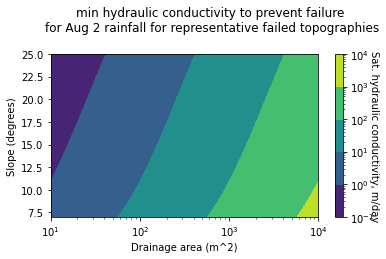

In [213]:
q_aug = .05; #[m/day] rain Aug 2 2020
z = 1; #active layer thickness, [m]
tanphi = .84; # original; tan (40 degrees) i think??? internal angle of friction
s_w_dens = 2; #ratio of density of saturated soil to water 
Ksat_maybe = 2.2; #m/day if 1/3 is organic and 2/3 is mineral 

slope_normal_array = np.cos(np.radians(slope_array))
k_aug_crit_matrix=np.zeros((pts,pts))

for i in range(len(da_array)):
    for j in range(len(slope_array)):
        k_aug_crit_matrix[i,j] = q_aug / ((np.sin(np.radians(slope_array[i])) *
                       (s_w_dens)) / da_array[j] )* (1 -  (np.tan(np.radians(slope_array[i])) / tanphi)) * z * slope_normal_array[i];

##Explore this param scape as function of soil thickness
from matplotlib import ticker, cm
fig, ax = plt.subplots(figsize=(6,3))
CS = ax.contourf(da_array,slope_array,k_aug_crit_matrix,locator=ticker.LogLocator())
#ax.clabel(CS, inline=1)
ax.set_xscale('log')
cbar = fig.colorbar(CS)
fig.suptitle('min hydraulic conductivity to prevent failure \nfor Aug 2 rainfall for representative failed topographies',y=1.1)
plt.ylabel('Slope (degrees)')
plt.xlabel('Drainage area (m^2)')
cbar.set_label('Sat. hydraulic conductivity, m/day', rotation=270)

### Make plot

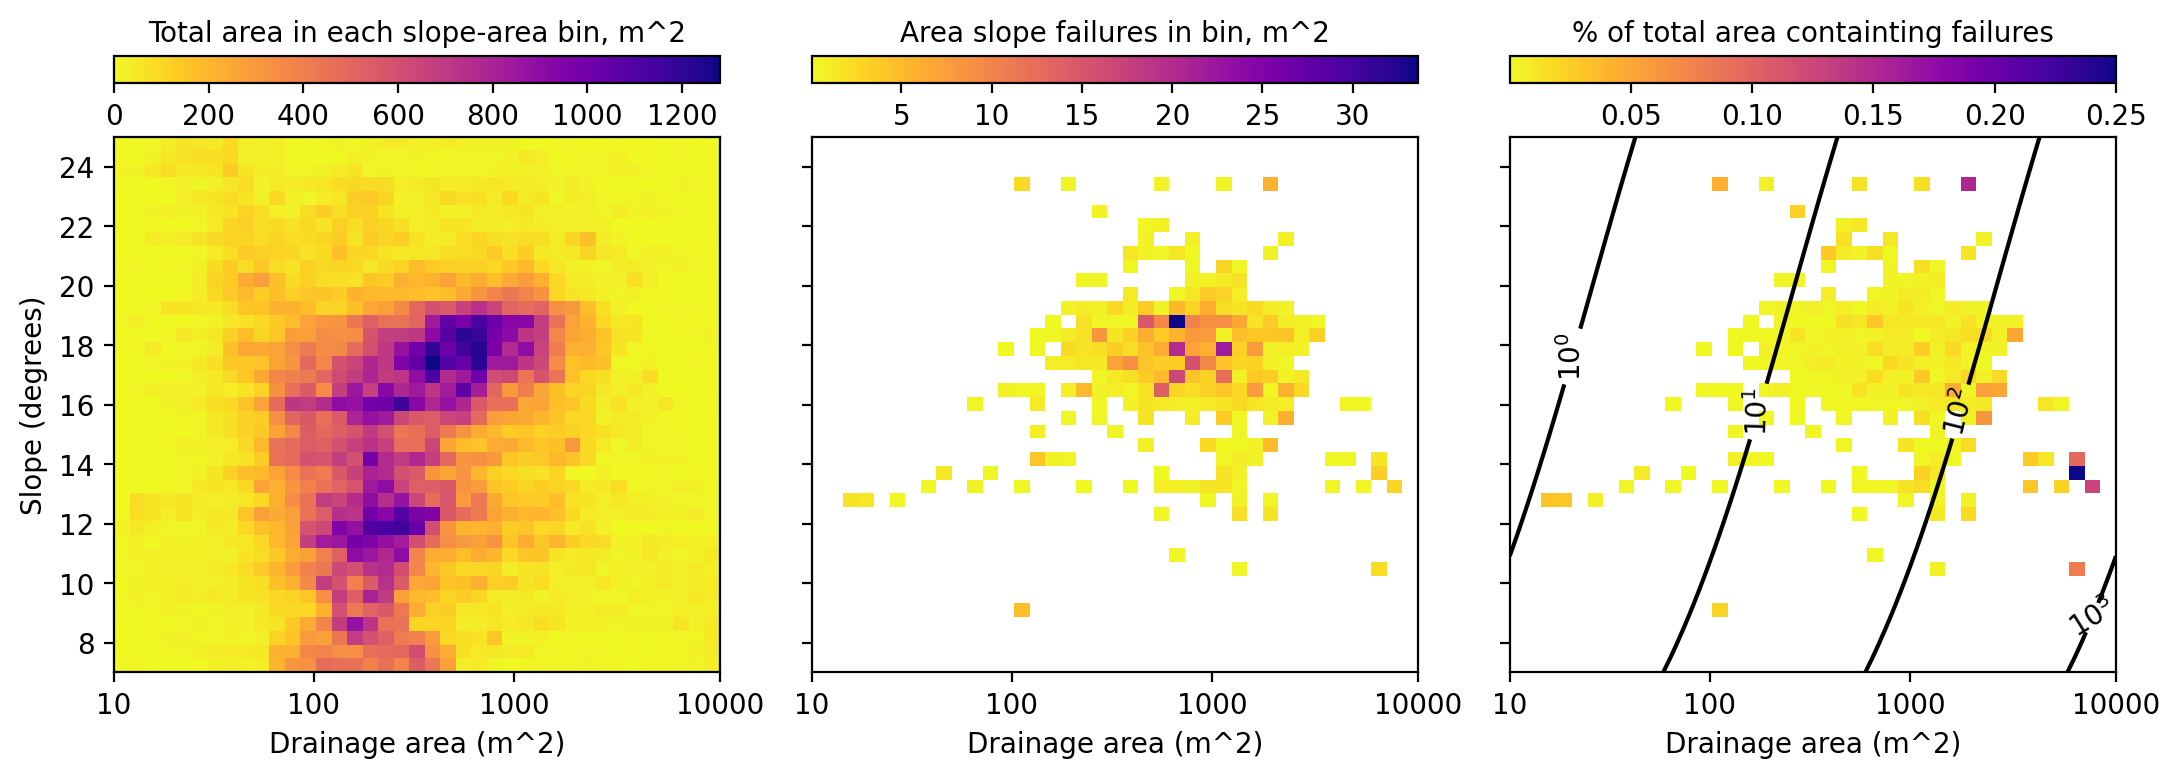

In [217]:
fig, ax = plt.subplots(1,3, figsize=(11,4),dpi=200, sharey=True)

im0 = ax[0].imshow(total_area_in_bin, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

# This is to fake log bins without making the axis truly log
ax[0].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[0].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[0])
# Add an axes to the right of the main axes.
cax0 = divider.append_axes("top", size="5%", pad="10%")
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_label('Total area in each slope-area bin, m^2', labelpad=-40);
ax[0].set_ylabel('Slope (degrees)')
ax[0].set_xlabel('Drainage area (m^2)')

im1 = ax[1].imshow(arr, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[1].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[1].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[1])
# Add an axes to the right of the main axes.
cax1 = divider.append_axes("top", size="5%", pad="10%")
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.set_label('Area slope failures in bin, m^2', labelpad=-40);
ax[1].set_xlabel('Drainage area (m^2)')

im2 = ax[2].imshow(prop_bin_failure_area, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[2].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[2].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[2])
# Add an axes to the right of the main axes.
cax2 = divider.append_axes("top", size="5%", pad="10%")
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal")
cb2.set_label('% of total area containting failures', labelpad=-40);
ax[2].set_xlabel('Drainage area (m^2)')

# Overlay contour where its x axis is actually logarithmic

twin = ax[2].twiny()
CS = twin.contour(da_array,slope_array,k_aug_crit_matrix, colors='k', locator=ticker.LogLocator())
fmt = ticker.LogFormatterMathtext()
#fmt.create_dummy_axis()
twin.clabel(CS, CS.levels, inline=True, colors= 'k', fmt=fmt, fontsize=10)
twin.set_xscale("log")
twin.axis("off")
divider = make_axes_locatable(twin)
# Add an axes to the right of the main axes.
cax_twin = divider.append_axes("top", size="5%", pad="10%")
cax_twin.axis("off")


fig.tight_layout()
plt.savefig("failures_in_slope_area_space.png")

### Old plots

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

fig, ax = plt.subplots(figsize=(4,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)


#CS = ax.contour(da_array,slope_array,k_aug_crit_matrix, #levels=[3e2,4e2,5e2],
#                 alpha=.9)
im = ax.imshow(prop_bin_failure_area, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')
# clabel = ax.clabel(CS, CS.levels, inline=True, 
#                 #fmt='0:.0f',
#                   fontsize=6)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('% of total area containting failures', rotation=270, labelpad=20);
#ax.set_xscale('log')

ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

fig, ax = plt.subplots(figsize=(4,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)


#CS = ax.contour(da_array,slope_array,k_aug_crit_matrix, #levels=[3e2,4e2,5e2],
#                 alpha=.9)
im = ax.imshow(total_area_in_bin, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')
# clabel = ax.clabel(CS, CS.levels, inline=True, 
#                 #fmt='0:.0f',
#                   fontsize=6)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('Total area in each slope-area bin, m^2', rotation=270, labelpad=20);
#ax.set_xscale('log')
ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

fig, ax = plt.subplots(figsize=(4,4),dpi=200)

#Y axis is rows in reshape (first value in reshape)


#CS = ax.contour(da_array,slope_array,k_aug_crit_matrix, #levels=[3e2,4e2,5e2],
#                 alpha=.9)
im = ax.imshow(arr, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')
# clabel = ax.clabel(CS, CS.levels, inline=True, 
#                 #fmt='0:.0f',
#                   fontsize=6)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('Mapped slope failures, m^2', rotation=270, labelpad=20);
#ax.set_xscale('log')
ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

### Experimenting with steepness

In [218]:
xx, yy = np.meshgrid(slope_array[:-1], da_array[:-1])
zz = xx * np.sqrt(yy) #Theodoratos and Kirchner, 2020 and Litwin et al 2021
# xx, yy = np.meshgrid(x, y)
# zz = np.sqrt(xx**2 + yy**2)

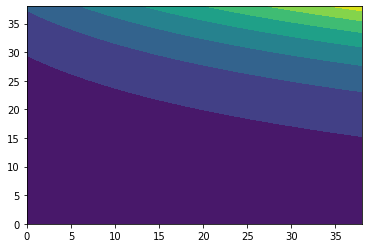

In [219]:
plt.contourf(zz)


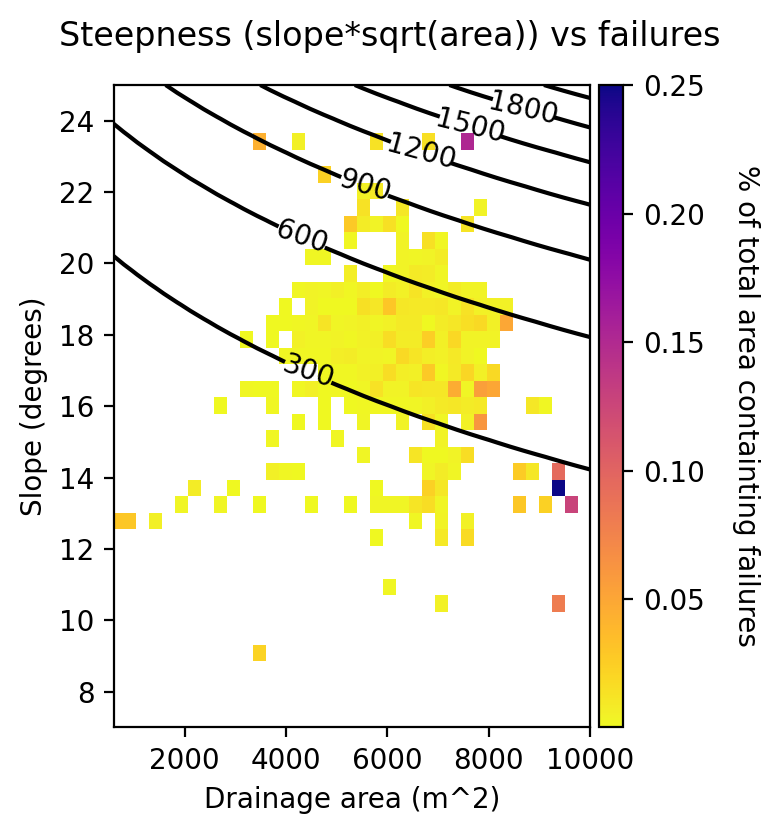

In [221]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

fig, ax = plt.subplots(figsize=(4,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)


#CS = ax.contour(da_array,slope_array,k_aug_crit_matrix, #levels=[3e2,4e2,5e2],
#                 alpha=.9)
im = ax.imshow(prop_bin_failure_area, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')
# clabel = ax.clabel(CS, CS.levels, inline=True, 
#                 #fmt='0:.0f',
#                   fontsize=6)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('% of total area containting failures', rotation=270, labelpad=20);
#ax.set_xscale('log')

CS = ax.contour(zz,extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],colors='k')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, colors='k')

ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

fig.suptitle("Steepness (slope*sqrt(area)) vs failures", y=1.03)

fig.tight_layout()
fig.savefig('steepness.png',dpi=300, bbox_inches = "tight")

In [ ]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib import colors

fig, ax = plt.subplots(figsize=(4,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)


#CS = ax.contour(da_array,slope_array,k_aug_crit_matrix, #levels=[3e2,4e2,5e2],
#                 alpha=.9)
im = ax.imshow(total_area_in_bin, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')
# clabel = ax.clabel(CS, CS.levels, inline=True, 
#                 #fmt='0:.0f',
#                   fontsize=6)

divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('% of total area containting failures', rotation=270, labelpad=20);
#ax.set_xscale('log')

CS = ax.contour(zz,extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],colors='k')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, colors='k')

ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

fig.suptitle("Steepness (slope*sqrt(area)) vs failures", y=1.03)

fig.tight_layout()
fig.savefig('testfig.png',dpi=300, bbox_inches = "tight")

In [ ]:
plt.scatter(zz, total_area_in_bin)

In [ ]:
plt.scatter(zz, arr)

In [ ]:
plt.scatter(zz, prop_bin_failure_area)

# Maps

# Extra

In [ ]:
## I had this idea, then I had another idea. 

# def resample_to_target_dims(raster, target_height, target_width):
#     t = raster.transform

#     # rescale the metadata
#     height = int(raster.height * scale)
#     width = int(raster.width * scale)
     
    
#     scale = t[0]/target_res
#     transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)


#     profile = raster.profile
#     profile.update(transform=transform, driver='GTiff', height=height, width=width)

#     data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
#             out_shape=(raster.count, height, width),
#             resampling=Resampling.cubic,
#         )

#     with MemoryFile() as memfile:
#         with memfile.open(**profile) as dataset: # Open as DatasetWriter
#             dataset.write(data)                     
#             del data

#         with memfile.open() as dataset:  # Reopen as DatasetReader
#             yield dataset  # Note yield not return    